# ECG classification

Laurent Cetinsoy - Datadidacte


In [90]:
from IPython.display import HTML
from scipy import stats
from scipy.fft import fft
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## A first naive model by extracting simple features


Your environment contains variables arr, nsr, and chf which respectively contain 10-second recordings of ECG signals extracted from three datasets on PhysioNet: one from a person suffering from arrhythmia, one from a person with a normal heart rhythm, and another from a person with heart failure.


Matplotlib  subplots (or any other library), display these signals on three subfigures (the subplots should be called with the parameter nrows = 3).
Can you find any differences between them?

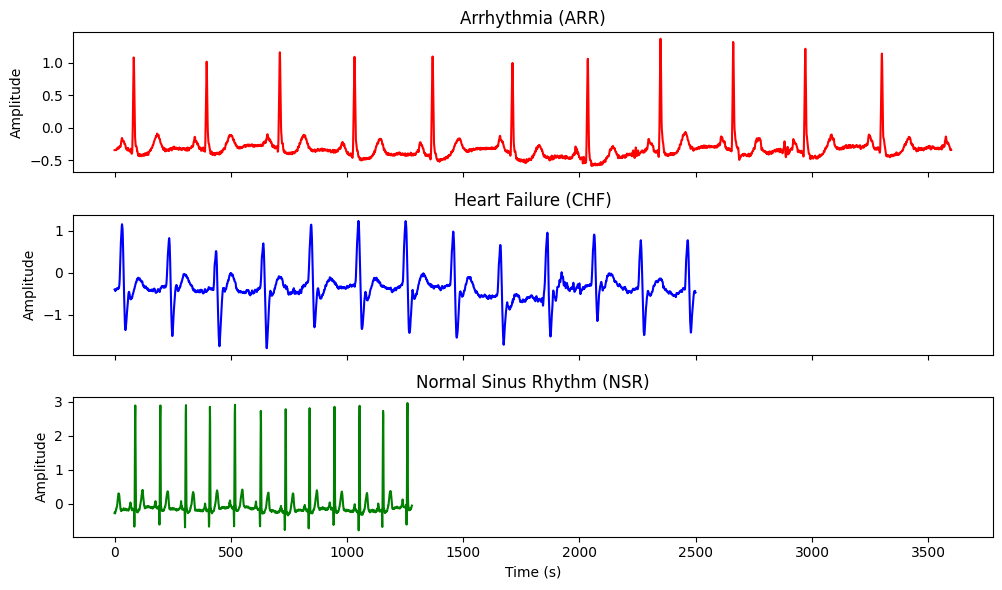

In [91]:
arr = np.loadtxt('arr.txt')
chf = np.loadtxt('chf.txt')
nsr = np.loadtxt('nsr.txt')

fig, axs = plt.subplots(nrows=3, figsize=(10, 6), sharex=True)

axs[0].plot(arr, color='r')
axs[0].set_title('Arrhythmia (ARR)')
axs[0].set_ylabel('Amplitude')

axs[1].plot(chf, color='b')
axs[1].set_title('Heart Failure (CHF)')
axs[1].set_ylabel('Amplitude')

axs[2].plot(nsr, color='g')
axs[2].set_title('Normal Sinus Rhythm (NSR)')
axs[2].set_ylabel('Amplitude')
axs[2].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()


We can observe differences in amplitude and frequency. Arrhytmia signal shows only positive amplitude, while heart failure signal has an amplitude varying between -1 and 1. Normal Sinus Rhythm signal has a maximum amplitude of 3 which is larger than the two other signals. It also has a higher frequency (the lowest one being Arrhytmia). 

We want to extract features from the time series. For that we will use simple statistics.


Create a function named calculate_stats_features(x) that calculates some statistical features of a signal x using standard numpy functions: nanpercentile, nanmean, etc.
calculate_stats_features will return a list of features in this order:

0. Max
1. Min
2. Mean
3. Median
4. Variance

In [92]:
def calculate_stats_features(x):
    x = np.array(x)

    return np.array([np.nanmax(x), np.nanmin(x), np.nanmean(x), np.nanmedian(x), np.nanvar(x)])

calculate_stats_features(arr)

array([ 1.375     , -0.59      , -0.31201111, -0.335     ,  0.03966355])



Create a function named `calculate_zero_crossing(x)` that calculates the Zero
Crossing of a signal x.

The zero crossing is defined as the number of times the signal changes sign.
For this, you can use the signbit, diff, and nonzero functions from numpy.


In [93]:
def calculate_zero_crossing(x):
    x = np.array(x)

    sign = np.signbit(x)
    sign_diff = np.diff(sign)

    return np.count_nonzero(sign_diff)

calculate_zero_crossing(arr)

22

Create a function named **calculate_rms(x)** that returns the Root Mean Square (RMS) of a signal x. We will use the nanmean function instead of the mean function from numpy.

In [94]:
def calculate_rms(x):
    x = np.array(x)
    x2 = np.square(x)

    return np.nanmean(x2)**(1/2)

calculate_rms(arr)

np.float64(0.37015467862923346)

Create a function named calculate_entropy(x) that calculates the Shannon entropy of a signal x using the entropy function from scipy.stats.

In [95]:
# Pour l'entropy vous pouvez calculer le compte de chaque valeur avec np.unique et le flag "counts" = True
# et ensuite utiliser la fonction entropy de scipy

def calculate_entropy(x):
    x = np.array(x)
    values, counts = np.unique(x, return_counts=True)
    probabilities = counts / counts.sum()

    return stats.entropy(probabilities)

calculate_entropy(arr)

np.float64(4.444550643807692)

Create a function get_features(x) that combines the features calculated by all previous functions including caculate_stats_features.

In [96]:
def get_features(x):
    res = calculate_stats_features(x)
    
    return np.append(res, [calculate_zero_crossing(x), calculate_rms(x), calculate_entropy(x)])

get_features(arr)

array([ 1.375     , -0.59      , -0.31201111, -0.335     ,  0.03966355,
       22.        ,  0.37015468,  4.44455064])

Load the small ecg dataset
Use your fonction get_features create a new dataframe where you have all the feature as X and y as the label.
Train a random forest on it after doing a train test split if the dataset is not too small

In [97]:
# for the ecg_small.csv
# the first column is to be droped
# the second column is the label
# the reste are the time serie

df = pd.read_csv("ecg_small_dataset.csv")
df.drop(columns=["0"], inplace=True)

new_columns = list(range(-1, df.shape[1] - 1))

df.columns = new_columns
df.rename(columns={-1: "y"}, inplace=True)

df

,y,0,1,2,3,4,5,6,7,8,...,15350,15351,15352,15353,15354,15355,15356,15357,15358,15359
0,1,-0.429539,-0.431368,-0.427633,-0.453029,-0.460659,-0.448497,-0.469340,-0.475054,-0.473138,...,-0.299412,-0.341126,-0.364847,-0.360565,-0.358913,-0.406275,-0.452011,-0.440424,-0.417412,-0.419938
1,1,-0.527040,-0.542357,-0.539678,-0.541406,-0.518841,-0.505650,-0.523337,-0.532713,-0.520244,...,-0.523533,-0.542245,-0.544550,-0.523466,-0.510608,-0.497607,-0.508469,-0.495939,-0.479749,-0.484566
2,2,-0.410425,-0.416644,-0.424048,-0.398195,-0.393680,-0.386315,-0.371686,-0.377065,-0.368017,...,-0.288222,-0.742357,-1.088831,-1.347331,-1.349561,-1.165759,-1.004126,-0.829844,-0.671777,-0.536377
3,2,-0.007009,-0.069041,-0.063572,-0.080944,-0.070556,-0.098701,-0.090165,-0.108852,-0.074475,...,-1.906522,-1.694052,-1.534222,-1.338660,-1.167661,-0.989236,-0.777201,-0.544748,-0.313120,-0.032588
4,0,-0.325000,-0.395000,-0.255000,-0.335000,-0.375000,-0.335000,-0.285000,-0.275000,-0.245000,...,-0.085000,-0.105000,-0.135000,-0.135000,-0.155000,-0.155000,-0.135000,-0.145000,-0.125000,-0.115000
5,0,-0.185000,-0.155000,-0.125000,-0.115000,-0.105000,-0.095000,-0.085000,-0.065000,-0.025000,...,-0.105000,-0.135000,-0.145000,-0.145000,-0.155000,-0.165000,-0.165000,-0.145000,-0.155000,-0.135000


In [98]:
def train_random_forest(df, split=True):
    y = df.iloc[:, 0]
    X_raw = df.iloc[:, 1:]

    X_features = X_raw.apply(get_features, axis=1)
    X_features = pd.DataFrame(X_features.tolist())
    X_features = X_features.set_axis(["Max", "Min", "Mean", "Median", "Variance", "Zero Crossing", "RMS", "Entropy"], axis=1)

    if split:
        X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=23)
    else:
        X_train, X_test, y_train, y_test = X_features, X_features, y, y
    
    model = RandomForestClassifier(random_state=23)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    y_pred_proba_test = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    return accuracy, log_loss(y_train, y_pred_proba_train), log_loss(y_test, y_pred_proba_test)


In [99]:
small_accuracy, small_train_loss, small_test_loss = train_random_forest(df, split=False)

print("Small dataset Accuracy:", small_accuracy)
print("Small dataset Train Loss:", small_train_loss)
print("Small dataset Test Loss:", small_test_loss)

Small dataset Accuracy: 1.0
Small dataset Train Loss: 0.1576641601492486
Small dataset Test Loss: 0.1576641601492486


Now you have a first pipeline, do the same on the full dataset
Report the train and test loss

In [100]:
!tar -xvf ECG_classification_full_dataset.zip

x ECG-laurent.csv
x __MACOSX/._ECG-laurent.csv


In [101]:
df = pd.read_csv("ECG-laurent.csv")
df.drop(columns=["0"], inplace=True)

new_columns = list(range(-1, df.shape[1] - 1))

df.columns = new_columns
df.rename(columns={-1: "y"}, inplace=True)

df

accuracy, train_loss, test_loss = train_random_forest(df)

print("Accuracy:", accuracy)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)


C:\Users\samya\AppData\Local\Temp\ipykernel_6356\3270559228.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ECG-laurent.csv")


Accuracy: 0.9393939393939394
Train Loss: 0.08502577157897984
Test Loss: 0.2340833860837585


try to tweak the model hyperparameter to see if it works

In [102]:
def train_random_forest_with_tuning(df):
    y = df.iloc[:, 0]
    X_raw = df.iloc[:, 1:]

    X_features = X_raw.apply(get_features, axis=1)
    X_features = pd.DataFrame(X_features.tolist())
    X_features = X_features.set_axis(["Max", "Min", "Mean", "Median", "Variance", "Zero Crossing", "RMS", "Entropy"], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=23)

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2'],
    }

    model = RandomForestClassifier(random_state=23)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=20, scoring='accuracy', n_jobs=-1, verbose=2)

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    y_pred_proba_test = best_model.predict_proba(X_test)
    y_pred_proba_train = best_model.predict_proba(X_train)

    return accuracy, log_loss(y_train, y_pred_proba_train), log_loss(y_test, y_pred_proba_test)


In [103]:
accuracy, train_loss, test_loss = train_random_forest_with_tuning(df)

print("Accuracy after tuning:", accuracy)
print("Train Loss after tuning:", train_loss)
print("Test Loss after tuning:", test_loss)

Fitting 20 folds for each of 243 candidates, totalling 4860 fits
Accuracy after tuning: 0.9393939393939394
Train Loss after tuning: 0.11941668928516723
Test Loss after tuning: 0.23153649298749582


c:\Users\samya\OneDrive\Documents\Epita\ING3\Machine Learning for biology\TPs\TP1\venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1020 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\samya\OneDrive\Documents\Epita\ING3\Machine Learning for biology\TPs\TP1\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\samya\OneDrive\Documents\Epita\ING3\Machine Learning for biology\TPs\TP1\venv\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_par

## Fourier transform features

We want now to see if a model using only fourier transform could work.

create a function get_fourier_coefficients(ecg)

In [104]:
def get_fourier_coefficients(ecg, n_coefficients=10):
    fourier_transform = np.fft.fft(ecg)
    coefficients = np.real(fourier_transform[:n_coefficients])

    return coefficients


Using this function create a dataframe df_fourrier containing the fourrier transform coefficients and the label

In [105]:
coeffs = df.iloc[:, 1:].apply(get_fourier_coefficients, axis=1).tolist()
fourier_features = pd.DataFrame(coeffs)

fourier_columns = [f"Fourier_{i}" for i in range(fourier_features.shape[1])]
fourier_features.columns = fourier_columns

df_fourier = pd.concat([df['y'], fourier_features], axis=1)
df_fourier.rename(columns={'y': 'Label'}, inplace=True)

df_fourier

,Label,Fourier_0,Fourier_1,Fourier_2,Fourier_3,Fourier_4,Fourier_5,Fourier_6,Fourier_7,Fourier_8,Fourier_9
0,1,-17599.976889,-758.813702,-93.278558,-592.319401,-305.129117,-385.483756,-791.780539,-459.654824,-1258.509759,315.708424
1,1,-14484.396444,-1625.487534,-1115.147467,-592.487213,-554.254257,-285.183354,296.268696,-204.265852,-1635.338876,865.993022
2,1,-10683.818667,385.954517,-196.939828,-224.784712,-96.282300,-673.024888,-577.757255,-508.416037,67.634488,-900.547863
3,1,3536.462222,-264.551162,-298.594840,446.614788,-613.430463,-244.125989,-561.247176,402.691658,-785.782374,-201.149215
4,1,-9756.496000,7.358478,464.681459,-467.787635,271.644373,98.127012,95.593713,-66.534328,865.344309,-182.809107
...,...,...,...,...,...,...,...,...,...,...,...
157,2,-14269.954560,-114.858793,-309.735790,1278.304613,1330.317789,-900.561977,257.355467,-1229.643825,220.827068,271.564130
158,2,-17730.076160,-257.018712,388.623358,20.955106,270.717265,70.750801,-719.264018,28.162601,428.122064,-31.913616
159,2,-11277.319680,1419.776177,-2064.807741,-262.156056,-764.666024,373.225324,297.878869,-573.869179,482.098265,299.976219
160,2,-22526.704640,-205.832889,-177.782769,80.923161,330.941976,-705.087782,666.857389,106.843119,323.296234,-255.137661


Try to train a model using the Fourrier coefficient

Try to learn a model using both fourrier coefficient and the features from the previous sections. Does it work ?

In [106]:
# Training using the Fourier coefficients
accuracy, train_loss, test_loss = train_random_forest(df_fourier)

print("Accuracy:", accuracy)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)


Accuracy: 0.9090909090909091
Train Loss: 0.07463502737289877
Test Loss: 0.16866143223851932


In [107]:
# Training using both fourier coefficients and the features from the previous sections
df_combined = pd.concat([df, df_fourier.iloc[:, 1:]], axis=1, ignore_index=True)

accuracy, train_loss, test_loss = train_random_forest(df_combined)

print("Accuracy:", accuracy)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)


Accuracy: 0.9090909090909091
Train Loss: 0.06755062579937324
Test Loss: 0.1371130445557947


The model using both Fourier coefficients and the other features works well too. Indeed, it achieves an accuracy of 90%.

## Wavelets

We now wants to use another signal decomposition which are called wavelet. Wavelet are a multi-scale function decomposition on a familly of functions generated from what is called a mother wavelet.

Using PyWavelet make a function get_wavelet_coefficients(ecg) that returns the wavelet coefficient of a given ECG


In [108]:
def get_wavelet_coefficients(ecg):
    coeffs = pywt.wavedec(ecg, 'db1', 1)
    res = np.concatenate([np.ravel(x) for x in coeffs])
    
    return res


Using the get_wavelet_coefficients, create a dataframe when the features are the coefficients and include the label

In [109]:
labels = df["y"]
ecg_signals = df.iloc[:, 1:]
wavelet_features = ecg_signals.apply(lambda x: get_wavelet_coefficients(x.values), axis=1)

df_wavelet_features = pd.DataFrame(wavelet_features.tolist())
df_wavelet_features = pd.concat([labels, df_wavelet_features], axis=1)

df_wavelet_features


,y,0,1,2,3,4,5,6,7,8,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,1,-68.749910,-11.826685,-2.399030,1.236612,-4.656965,-2.297531,2.591033,-2.478539,-5.257261,...,0.065699,0.016719,0.053518,0.021233,0.014724,-0.040096,-0.045579,-0.042910,0.038852,0.117287
1,1,-56.579674,-27.244620,-14.731033,-5.047685,-14.456471,-0.901384,-3.216877,-3.811263,-8.080177,...,-0.010720,-0.015836,-0.018014,-0.048044,-0.036967,-0.004891,0.054351,0.036088,-0.000337,-0.029607
2,1,-41.733667,0.722720,2.982323,0.895042,2.758237,3.510943,3.709214,-0.779515,0.150140,...,-0.023410,0.025392,0.068484,0.084473,0.207043,-0.089120,-0.153329,-0.082890,-0.055987,-0.014258
3,1,13.814306,1.704916,-3.692958,-1.195417,-0.892720,-0.224864,-1.461370,2.788254,-6.178901,...,-0.017118,0.011268,0.044394,0.175267,-0.045659,-0.127169,-0.135989,0.065010,0.080593,0.014107
4,1,-38.111313,0.902173,1.229560,0.112356,-1.572446,-2.597243,2.557756,-2.462871,0.371768,...,0.013890,0.004778,-0.050799,-0.437964,0.558049,-0.084620,0.043570,-0.033640,-0.107628,-0.159106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,2,-55.742010,-2.310511,-4.080631,-0.178576,4.209655,3.885352,-5.758373,-2.496058,0.799210,...,-0.079195,-0.046403,-0.056491,-0.031241,-0.029014,-0.020844,0.005015,-0.011970,0.002185,0.006545
158,2,-69.258110,2.239943,-2.047848,0.236823,3.103182,-1.688571,1.095972,-1.139634,-0.896450,...,-0.024171,0.017110,0.000482,-0.025721,-0.000338,-0.018288,-0.005972,-0.007668,-0.016222,-0.019366
159,2,-44.052030,-1.130235,11.948362,0.377006,-7.534129,5.860613,-6.197356,1.092782,-4.880049,...,-0.020154,-0.010923,-0.031767,-0.007734,0.033134,-0.004324,0.016074,0.000579,0.005376,-0.000354
160,2,-87.994940,1.004045,-3.470357,-0.537768,-2.323872,2.437140,-1.456344,1.006387,0.107079,...,-0.057088,-0.065876,-0.015059,0.023097,0.015839,0.014198,0.008636,0.030311,0.054237,0.060466


Train a random forest classifier with such features. DOes the model work

In [110]:
accuracy, train_loss, test_loss = train_random_forest(df_wavelet_features)

print("Accuracy:", accuracy)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

Accuracy: 0.9696969696969697
Train Loss: 0.08846661877297089
Test Loss: 0.2164869373823215


The model seems to work very well. Indeed, it achieved an accuracy of almost 97%.

Add one or several of the previous feature functions and try to train another model

In [111]:
df_total_combined = pd.concat([df_wavelet_features, df_combined.iloc[:, 1:]], axis=1)
new_columns = list(range(-1, df_total_combined.shape[1] - 1))
df_total_combined.columns = new_columns

df_total_combined.rename(columns={-1: "y"}, inplace=True)

df_total_combined


,y,0,1,2,3,4,5,6,7,8,...,131072,131073,131074,131075,131076,131077,131078,131079,131080,131081
0,1,-68.749910,-11.826685,-2.399030,1.236612,-4.656965,-2.297531,2.591033,-2.478539,-5.257261,...,-17599.976889,-758.813702,-93.278558,-592.319401,-305.129117,-385.483756,-791.780539,-459.654824,-1258.509759,315.708424
1,1,-56.579674,-27.244620,-14.731033,-5.047685,-14.456471,-0.901384,-3.216877,-3.811263,-8.080177,...,-14484.396444,-1625.487534,-1115.147467,-592.487213,-554.254257,-285.183354,296.268696,-204.265852,-1635.338876,865.993022
2,1,-41.733667,0.722720,2.982323,0.895042,2.758237,3.510943,3.709214,-0.779515,0.150140,...,-10683.818667,385.954517,-196.939828,-224.784712,-96.282300,-673.024888,-577.757255,-508.416037,67.634488,-900.547863
3,1,13.814306,1.704916,-3.692958,-1.195417,-0.892720,-0.224864,-1.461370,2.788254,-6.178901,...,3536.462222,-264.551162,-298.594840,446.614788,-613.430463,-244.125989,-561.247176,402.691658,-785.782374,-201.149215
4,1,-38.111313,0.902173,1.229560,0.112356,-1.572446,-2.597243,2.557756,-2.462871,0.371768,...,-9756.496000,7.358478,464.681459,-467.787635,271.644373,98.127012,95.593713,-66.534328,865.344309,-182.809107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,2,-55.742010,-2.310511,-4.080631,-0.178576,4.209655,3.885352,-5.758373,-2.496058,0.799210,...,-14269.954560,-114.858793,-309.735790,1278.304613,1330.317789,-900.561977,257.355467,-1229.643825,220.827068,271.564130
158,2,-69.258110,2.239943,-2.047848,0.236823,3.103182,-1.688571,1.095972,-1.139634,-0.896450,...,-17730.076160,-257.018712,388.623358,20.955106,270.717265,70.750801,-719.264018,28.162601,428.122064,-31.913616
159,2,-44.052030,-1.130235,11.948362,0.377006,-7.534129,5.860613,-6.197356,1.092782,-4.880049,...,-11277.319680,1419.776177,-2064.807741,-262.156056,-764.666024,373.225324,297.878869,-573.869179,482.098265,299.976219
160,2,-87.994940,1.004045,-3.470357,-0.537768,-2.323872,2.437140,-1.456344,1.006387,0.107079,...,-22526.704640,-205.832889,-177.782769,80.923161,330.941976,-705.087782,666.857389,106.843119,323.296234,-255.137661


In [112]:
accuracy, train_loss, test_loss = train_random_forest(df_total_combined)

print("Accuracy:", accuracy)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

Accuracy: 0.9393939393939394
Train Loss: 0.05955202621240153
Test Loss: 0.13175895913284358


The random forest seems to perform very well on this data. Indeed, it achieves an accuracy reaching almost 94%.

Specify the methodology you used to train the model and report the various attempts results into a table

#### 1. Data preparation:
Different representations of the ECG signals were used as features, including:
- Statistical features (Max, Min, Mean, Median, Variance, Zero Crossing, RMS, Entropy).
- Fourier coefficients (using Discrete Fourier Transform).
- Wavelet coefficients (using Discrete Wavelet Transform).
- A combination of these features.

#### 2. Feature Extraction:
- Statistical Features: Extracted using predefined functions `get_features` applied to the raw ECG signals.
- Fourier Coefficients: Extracted using the `get_fourier_coefficients` function.
- Wavelet Coefficients: Extracted using the `get_wavelet_coefficients` function.

#### 3. Model Training:
- The Random Forest Classifier was used to train the model on each feature set.
- A train-test split was applied (80-20 split) to evaluate the model's performance.
- Model performance was evaluated using Accuracy, Train Loss, and Test Loss.

#### 4. Combination of Features:
Feature sets were concatenated to form combined datasets for testing the impact of using multiple feature representations together.

| Features Used                    | Accuracy | Train Loss | Test Loss |
|----------------------------------|----------|------------|-----------|
| Statistical Features Only        | 0.9394   | 0.0850     | 0.2341    |
| Fourier Coefficients Only        | 0.9091   | 0.0746     | 0.1687    |
| Combined (Statistical + Fourier) | 0.9091   | 0.0676     | 0.1371    |
| Wavelet Coefficients Only        | 0.9697   | 0.0885     | 0.2165    |
| All Features Combined            | 0.9394   | 0.0596     | 0.1318    |


## Deep learning (1D CNN)

Now we want to see if we can skip all theses feature engineering techniques !
Design and train a multi-layer one dimensional CNN using the raw ECG signal as features.


Could you reach or surpass the feature based models ?

In [113]:
class ECGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [114]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(524288, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [115]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.unsqueeze(1)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100 * correct / total
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_acc:.2f}%\n")


In [116]:
labels = df["y"]
data = df.iloc[:, 1:]

X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

train_dataset = ECGDataset(X_train, y_train)
val_dataset = ECGDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = CNN(num_classes=len(labels.unique()))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, val_loader, num_epochs=20, criterion=criterion, optimizer=optimizer)


Epoch [1/20], Loss: 36.4990, Accuracy: 38.76%
Validation Loss: 11.1891, Validation Accuracy: 18.18%

Epoch [2/20], Loss: 11.5221, Accuracy: 47.29%
Validation Loss: 5.2212, Validation Accuracy: 57.58%

Epoch [3/20], Loss: 7.2050, Accuracy: 57.36%
Validation Loss: 3.0011, Validation Accuracy: 57.58%

Epoch [4/20], Loss: 3.2372, Accuracy: 58.14%
Validation Loss: 0.7644, Validation Accuracy: 63.64%

Epoch [5/20], Loss: 1.4504, Accuracy: 58.91%
Validation Loss: 0.4701, Validation Accuracy: 63.64%

Epoch [6/20], Loss: 0.7437, Accuracy: 62.79%
Validation Loss: 0.3297, Validation Accuracy: 72.73%

Epoch [7/20], Loss: 0.4575, Accuracy: 79.84%
Validation Loss: 0.3045, Validation Accuracy: 72.73%

Epoch [8/20], Loss: 0.4495, Accuracy: 83.72%
Validation Loss: 0.2873, Validation Accuracy: 75.76%

Epoch [9/20], Loss: 0.3268, Accuracy: 81.40%
Validation Loss: 0.2806, Validation Accuracy: 69.70%

Epoch [10/20], Loss: 0.2419, Accuracy: 92.25%
Validation Loss: 0.2315, Validation Accuracy: 78.79%

Epoch 